In [1]:
#for Data
import math
import pandas as pd
import pandas_datareader as web
import numpy as np 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sys 
sys.path.append("../Function/")
from function import remove_high_corr
from function import remove_outliers
from sklearn.preprocessing import MinMaxScaler

# pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#for NN
import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.layers import Dropout
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


In [2]:
df = web.DataReader('AAPL',data_source='yahoo',start = '2012-01-01',end='2019-12-17')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.575917
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.643497
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.783868
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.917507
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.897017
...,...,...,...,...,...,...
2019-12-11,67.775002,67.125000,67.202499,67.692497,78756800.0,66.616837
2019-12-12,68.139999,66.830002,66.945000,67.864998,137310400.0,66.786598
2019-12-13,68.824997,67.732498,67.864998,68.787498,133587600.0,67.694435


In [3]:
df.shape

(2003, 6)

Text(0, 0.5, 'Close price USD($)')

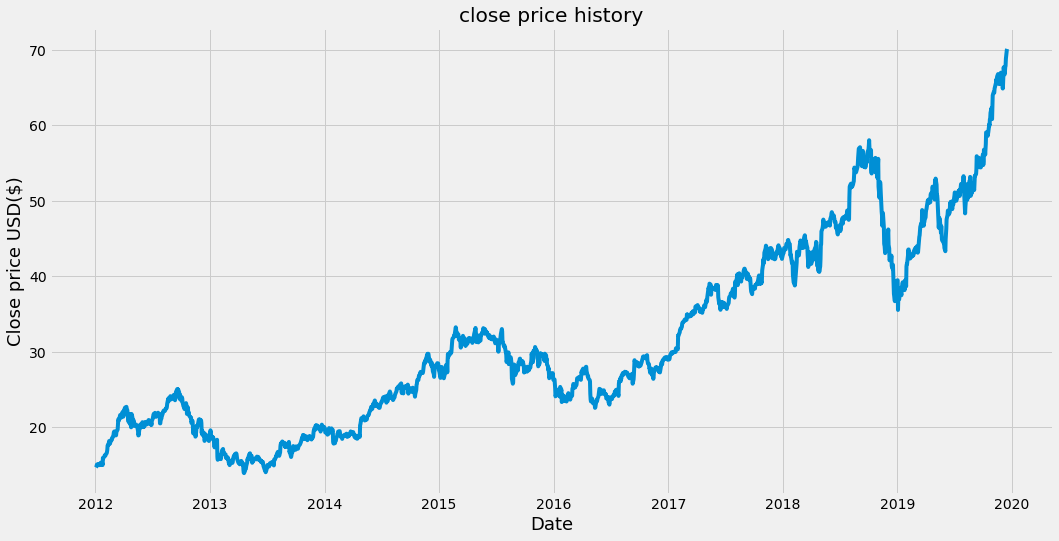

In [4]:
#visualize the closing price history 
plt.figure(figsize=(16,8))
plt.title("close price history")
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel("Close price USD($)",fontsize=18)

In [14]:
#Create a new DataFrame only with close column
data = df.filter(['Close'])
#Convert the dataframe to a numpy array
dataset = data.values
#get the number of rows to train the model on 
training_data_len = math.ceil(len(dataset)*0.8)
training_data_len

1603

In [15]:
#scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.01316509],
       [0.01457063],
       [0.01748985],
       ...,
       [0.97658263],
       [0.99755134],
       [1.        ]])

In [16]:
#Create the Training data set
#create the scaled training data set

train_data = scaled_data[0:training_data_len,:]
#split to X_train and y_train data sets

x_train=[]
y_train=[]

for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

#Convert the X_train and y_train to numpy arrays
x_train,y_train = np.array(x_train),np.array(y_train )

In [17]:
#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1543, 60, 1)

In [21]:
#Build the LSTM model
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [22]:
#Compile the model
model.compile(optimizer='adam',loss='mean_squared_error')

In [23]:
#train the model.
model.fit(x_train,y_train,batch_size=1,epochs=1)

1543/1543 [==============================] - 44s 27ms/step - loss: 0.0010


In [24]:
#Create the tasting data set
#Create a new array containing scaled values
test_data=scaled_data[training_data_len-60:,:]
#Create the data sets x_test and y_test
x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [25]:
#Convert the data to a numpy array
x_test = np.array(x_test)

In [26]:
#Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
x_test.shape

(400, 60, 1)

In [29]:
#Get the mpdeles predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions )


In [30]:
#Get the RMSE
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

1.219639081954956

C:\Users\asars\AppData\Local\Temp/ipykernel_4044/103415518.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


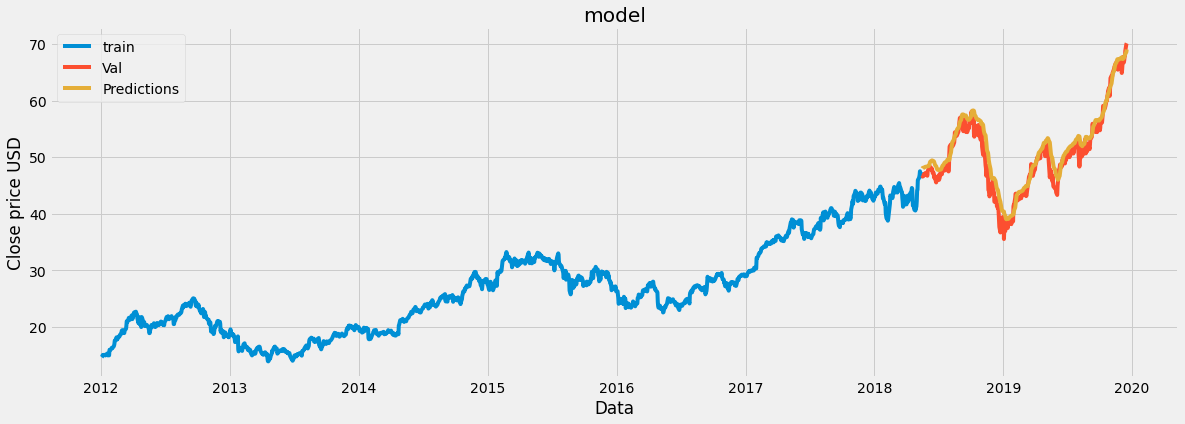

In [34]:
#plot the data 
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(18,6))
plt.title("model")
plt.xlabel("Data")
plt.ylabel("Close price USD")
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['train','Val','Predictions'])
plt.show()

In [35]:
#Show the valid and the prediction price
valid

,Close,Predictions
Date,,
2018-05-17,46.747501,48.011765
2018-05-18,46.577499,48.111774
2018-05-21,46.907501,48.145321
2018-05-22,46.790001,48.181995
2018-05-23,47.090000,48.200756
...,...,...
2019-12-11,67.692497,67.808083
2019-12-12,67.864998,68.020195
2019-12-13,68.787498,68.246552


In [38]:
#get the quote 
apple_quote = web.DataReader('AAPL',data_source='yahoo',start='2012-01-01',end='2019-12-17')
#Create a new DataFrame
new_df=apple_quote.filter(['Close'])
#get the last 60 dat closing price values and convert the datafrem to an array 
last_60_days = new_df[-60:].values
#Scaled the data to be values between 0 - 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = [] 
#Append the past 60 days
X_test.append(last_60_days_scaled)
#convert the x_test data set to numpy array
X_test = np.array(X_test)
#Rehsape the data
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
#Get the predicited scaled price
pred_price = model.predict(X_test)
#undo scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[69.476074]]


In [40]:
apple_quote2 = web.DataReader('AAPL',data_source='yahoo',start='2019-12-18',end='2019-12-18')
apple_quote2

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-18,70.474998,69.779999,69.949997,69.934998,116028400,68.823692
